# Data Manipulation & Analysis in Python

Now that we have imported data, often we want to use it to determine certain experimental observables. A peak wavelength from a UV/VIS spectra, a lifetime from concentration data, or chemical shift peaks in NMR. There are a multitude of ways to use this data to perform operations, and here we will just present a few.

Let's start with some NMR data of Ag~2~ZnSnS~4~ (AZTS) nanocrystals ([Yarur, F. *et al.* (Wilson), **2023.** *ChemRxiv*](https://chemrxiv.org/engage/chemrxiv/article-details/63e465cb3067856f18bc31f3)) labelled `D1 AZTS crude.csv`, using our template from the Importing Data section. Remember though, first we should always just *open up the data* to see what it looks like to figure out how to import it

![image.png](images/nmr_data.png)

What we can notice is that, despite being a .csv file, the data is not comma delimited. In fact, there's just a space between each number. Now we know what parameters to pass to import properly!

ppm =  [-2.0181  -2.01786 -2.01761 ... 14.0179  14.0181  14.0184 ]
signal =  [-0.0377323 -0.0383906 -0.0410056 ...  0.0453818  0.0463226  0.0456263]


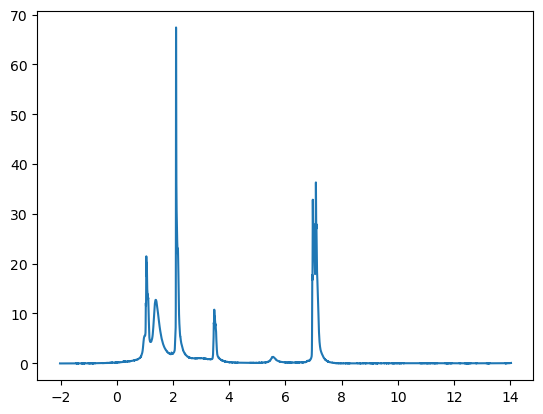

In [1]:
### IMPORT AND ROUGH PLOT DATA
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# define where our file can be found to be imported
filepath        = 'data/D1 AZTS crude.csv'

# label each variable something relevant to what it represents
ppm, signal             = np.genfromtxt(filepath,           # string, filepath to data
                                 dtype=float,       # data is float
                                 delimiter='',      # data is separated by spaces/tabs, so leave this blank
                                 skip_header=0,     # when we look, data has no header, so we set this to zero
                                 unpack=True)       # first column is ppm, second column is absorption

# print and plot data to try and look if data imported properly
print('ppm = ',ppm)
print('signal = ',signal)

plt.plot(ppm,signal) # plt.plot(xvalues, yvalues)

## Truncating data with boolean logic

`````{admonition} For CHM223 students
:class: important
This subsection is relevant for your assignment!
`````

While we can modify the limits of our plots to highlight specific regions of interest, we also might frequently want to truncate our data itself. In particular, if we are trying to do any integration over our entire spectra, or normalize our data to a local extrema versus an absolute that isn't physically relevant (due to error, laser, instrumentation, etc.).

Luckily, python has easy ways for us to modify our data accordingly using **boolean logic** (For a refresher, check out computational assignment X.) Given an array, we can check each value within an array against a condition, such as smaller than a certain number. This will return an array of the same size with only boolean values of `True` or `False`. 

Lets use the NMR data above for example. Say we only care about data where ppm is less than 10. We can check which values corruspond to less than 10 ppm as follows:

`print(ppm < 10)`

which returns

`[ True  True  True True True ...  False False False False False]`

why this is useful, is we can use this array of boolean values to modify our original array, or the signal array which corrusponds to those x values (pmm values), where we only keep every value where the entry is true. See below

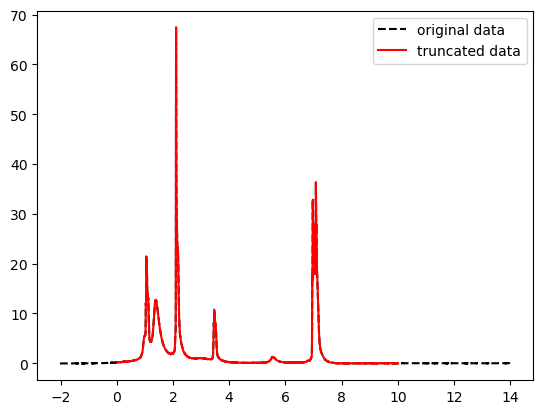

In [3]:
# import data
filepath        = 'data/D1 AZTS crude.csv'
ppm, signal = np.genfromtxt(filepath, dtype=float, delimiter='', skip_header=0, unpack=True)

# plot our data, unmodified
plt.plot(ppm,signal,'--',color='black',label='original data',)

# modify the ppm and signal arrays to only include values where the signal is less than 10
signal = signal[ppm < 10]   # first, modify the y values to corruspond to when the x values are less than 10
ppm = ppm[ppm < 10]         # then, modify the x values to corruspond to when the x values are less than 10

# furthermore, we might also want to only include values where ppm is greater than 0
signal = signal[ppm > 0]    # first, modify the y values to corruspond to when the x values are greater than 0
ppm = ppm[ppm > 0]          # then, modify the x values to corruspond to when the x values are greater than 0

# plot our truncated data
plt.plot(ppm,signal,color='red',label='truncated data')
plt.legend()

# We can also do the same operations above but with a single line of code for array of data
# the & symbol allows us to do multiple comparisons at once, as long as we put each comparison in parentheses ()
ppm, signal = np.genfromtxt(filepath, dtype=float, delimiter='', skip_header=0, unpack=True)
signal = signal[(ppm < 10) & (ppm > 0)] # first, modify the y values to corruspond to when the x values are less than 10 and greater than 0
ppm = ppm[(ppm < 10) & (ppm > 0)] # then, modify the x values to corruspond to when the x values are less than 10 and greater than 0




## Finding peaks: scipy.find_peaks

`````{admonition} For CHM223 students
:class: important
This subsection is relevant for your assignment!
`````

scipy, like numpy or matplotlib, is another package for python that includes a large number of functions useful for science and data analysis. One of the many included is the function `find_peaks()`, which allows us to locate peaks in an array of values in order to determine their positions, not unlike in FTIR software.

The function is used as follows:

`peaks , _ = scipy.find_peaks(data, height = x, width = y, prominence = z)`

where the created array `peaks` will be an array of all the positions (i.e. indices) in the original array where the peaks are found. For example, a value of `34` in the `peaks` array would imply we have a peak located at `data[34]`. For those interested, the underscore in `, _` just represents that for all the other things the function returns, we don't care about them and want to throw them away.

There are a few important controls for this function:
- `height =` will specify a threshold for the minimum height of a peak. If we know our background signal, this means we will never obtain any local minimum that may appear from a fluctuating background for example.
- `width =` will specify the expected width between neighbouring peaks. This is useful if we know that our data is well separated, as alongside height, we can specify that peaks we care about should be above a value of 1, while also being no less than 0.5 units apart from each other.
- `prominence =` is the most elusive of all but arguably the most useful. It helps create a threshold of peak values by defining *the minimum height necessary to descend to get from a peak to any other peak*. **Often, the proper use of prominence will mean we don't require any other controls, as highlighted in the example below**

 We can see an example of analyzing NMR data below



peaks located at  [1.05098 1.06786 1.38916 2.10859 2.17466 3.46768 5.56162 6.95398 6.97258
 6.9973  7.01516 7.06386 7.08245]


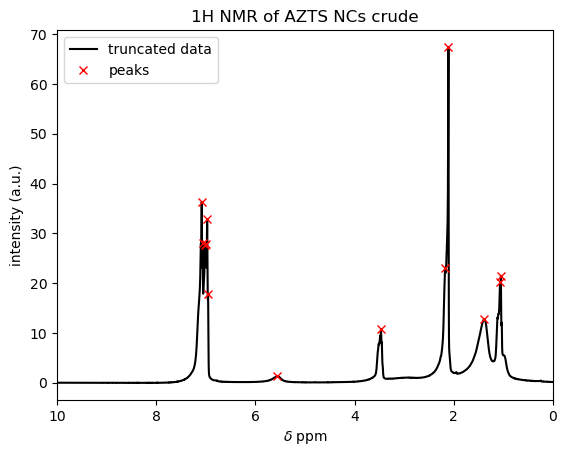

In [4]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# define where our file can be found to be imported
filepath        = 'data/D1 AZTS crude.csv' # sourced from E:\Dropbox (WilsonLab)\WilsonLab Team Folder\Projects\2021-04 - AZTS (SilKets) NCs\NMR

# import data, using our template from the previous section
ppm, signal            = np.genfromtxt(filepath,
                                 dtype=float,
                                 delimiter='',
                                 skip_header=0,
                                 unpack=True)

# first, truncate our data to regions we care about

signal = signal[(ppm < 10) & (ppm > 0)] # first, modify the y values to corruspond to when the x values are less than 10 and greater than 0
ppm = ppm[(ppm < 10) & (ppm > 0)]       # then, modify the x values to corruspond to when the x values are less than 10 and greater than 0

# plot the data
plt.plot(ppm,signal,color='black',label='truncated data')


# find peaks and plot them
peaks , _ = find_peaks(signal, height=0.1,prominence=1)
plt.plot(ppm[peaks], signal[peaks], "x",label='peaks',color='red')

# flip x-axis; how nmr people do it!
plt.xlim(10,0)

# label x and y axis and add a title
plt.xlabel('$\delta$ ppm')
plt.ylabel('intensity (a.u.)')
plt.title('1H NMR of AZTS NCs crude') # change title to match sample name
plt.legend() # show a legend with the labels we defined earlier
print('peaks located at ',ppm[peaks]) # print the ppm values of the peaks



## Background subtraction

A very common correction you will need to do to experimental data is background subtraction. Some softwares from instruments will do this automatically when you do a blank measurement, but others (and quite often, you would preferably) record a blank/background measurement, then record your samples.

Sometimes this can be as simple as subtracting a constant amount from all your data. Turning to our previous fluorescence spectra example, we see a stable amount of signal that is above zero outside of the range of wavelengths where we would expect photoluminescence (mainly, <300 nm and >900 nm). We therefore may want to find out what this value is, and subtract that value from *every* value in our intensity array, as that would could as our background signal. we can do that using the following array manipulation

`intens = intens - 315`

All this does is take every element of the `array` we defined as `intensity`, and subtract the value of `315` from it. As an example, lets do this with the data we imported in the **Importing Data** module

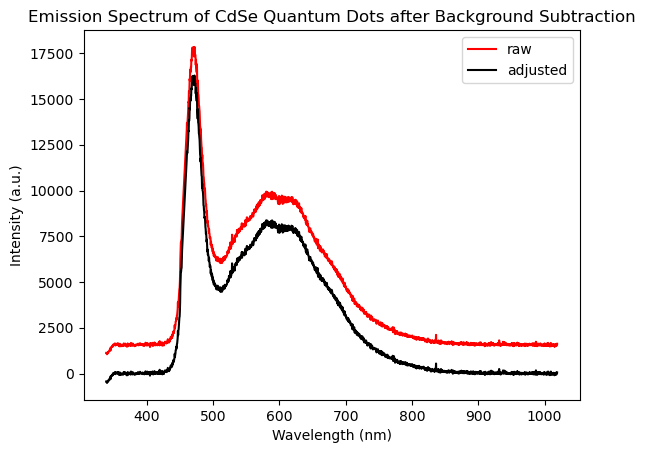

In [5]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# define where our file can be found to be imported
filepath        = 'data/CdSe_EmissionSpectra.txt'

x, y            = np.genfromtxt(filepath,
                                 dtype=float,
                                 delimiter='',
                                 skip_header=14,
                                 unpack=True)

# plot to try and look if data imported properly

plt.plot(x,y,color='red',label='raw') # plt.plot(xvalues, yvalues)
bg = 315 + 1250        # define background signal intensity
y = y - bg     # subtract background

plt.plot(x,y,color='black',label='adjusted')
#plt.xlim(400,900)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.title('Emission Spectrum of CdSe Quantum Dots after Background Subtraction')
plt.legend()


## Normalization. 
Another common practice is normalization, especially when there are certain features you want to highlight, or if you want to have a better comparison between distinct measurements.

`intens = intens/max(intens)`

However, often we will only be interested in determining a local maximum to normalize too. Here, we can utilize truncation to say we only want a maximum between a certain range. See below for an example:

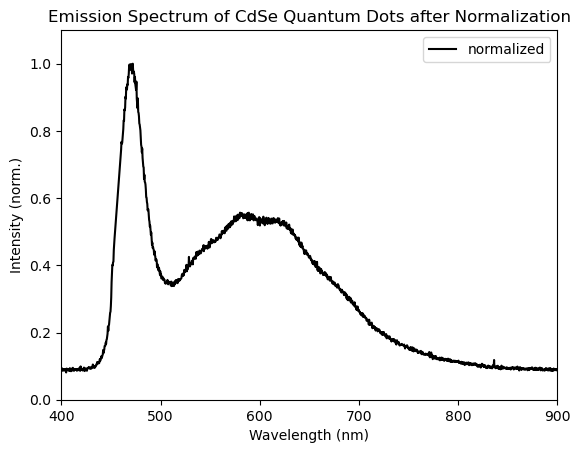

In [6]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# define where our file can be found to be imported
filepath        = 'data/CdSe_EmissionSpectra.txt'

x, y            = np.genfromtxt(filepath,
                                 dtype=float,
                                 delimiter='',
                                 skip_header=14,
                                 unpack=True)

# TBD Move local maximum w truncation to after we introduce it near the nmr section
# locate local maximum between 400 and 500
#local_y = y[(x > 400) & (x < 500)] # truncate y values to x values between 400 and 500
#local_max = max(local_y) # find local max between 400 and 500

# print local maximum and its location
#print('local max is equal to', local_max,'and located at x = ', x[y == local_max])

local_max = max(y) # find global maximum

# normalize by local maximum
y = y/local_max

# plot normalized data
plt.plot(x,y,color='black',label='normalized')

# we can also subtract the background, however we usually do that before normalizing and wont do it here

plt.xlim(400,900)
plt.ylim(0,1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (norm.)')
plt.title('Emission Spectrum of CdSe Quantum Dots after Normalization')
plt.legend()

This is especially useful when comparing distinct spectra, such as in the case where we need to import multiple files.

## Flipping data

Sometimes, the order in which instruments record data is not necessarily how we want to plot it or analyze it. For example, let's say we want to plot the emission by energy rather than wavelength. For reference, we can convert from wavelength of emission to energy in electronvolts by the following:

$$
E_{\lambda} = \frac{1239.8}{\lambda}  \text{ eV}
$$

So we can easily plot emission intensity versus energy as follows:

Text(0.5, 1.0, 'Emission Spectrum of CdSe Quantum Dots, energy x-axis')

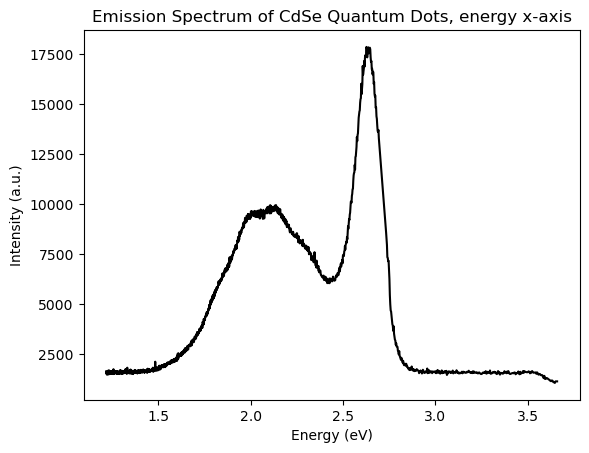

In [7]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# define where our file can be found to be imported
filepath        = 'data/CdSe_EmissionSpectra.txt'

wave, intensity            = np.genfromtxt(filepath,
                                 dtype=float,
                                 delimiter='',
                                 skip_header=14,
                                 unpack=True)

# calculate a new energy array from wavelength array
ev = 1239.8/wave

# plot normalized data by ev instead of wavelength
plt.plot(ev,intensity,color='black')

# we can also subtract the background, however we usually do that before normalizing and wont do it here

plt.xlabel('Energy (eV)')
plt.ylabel('Intensity (a.u.)')
plt.title('Emission Spectrum of CdSe Quantum Dots, energy x-axis')

Generally we plot energy from highest to lowest, however by default `matplotlib` plots from lowest to highest values. This is common for many other plots, such as NMR plots which we will see later below. We can easily fix this by reversing the order of our axis limits to `plt.xlim(max,min)` rather than the typical min, max order. We can easily obtain the minimum and maximum values for our x-axis by calling `max(x)` and `min(x)` respectively, where `x` is whatever label we use for our x-data. See below for example

Text(0.5, 1.0, 'Emission Spectrum of CdSe Quantum Dots, reversed energy x-axis')

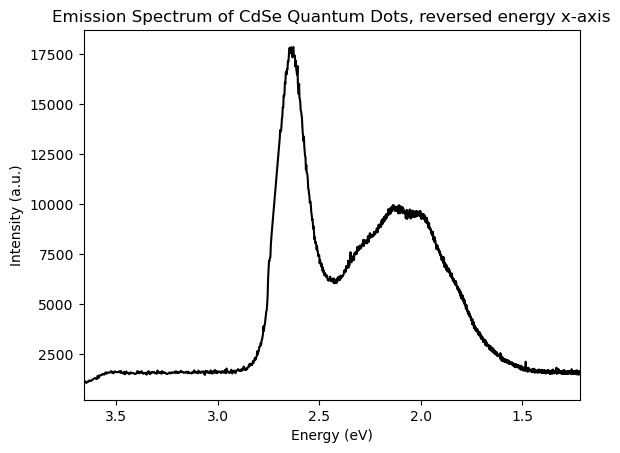

In [8]:
# plot data
plt.plot(ev,intensity,color='black')

# reverse x-axis, to go in descending order. Often used when plotting quantities related to energy.
plt.xlim(max(ev),min(ev))

plt.xlabel('Energy (eV)')
plt.ylabel('Intensity (a.u.)')
plt.title('Emission Spectrum of CdSe Quantum Dots, reversed energy x-axis')

Additionally, We also may want to do this with our data arrays themselves. To do this, we can simply use `np.flip` as below on our NMR data for example

In [9]:
print('original array:',ev)
ev_flipped = np.flip(ev)
print('flipped array:',ev_flipped)

original array: [3.65988298 3.65573896 3.65161507 ... 1.21765332 1.21732215 1.21699115]
flipped array: [1.21699115 1.21732215 1.21765332 ... 3.65161507 3.65573896 3.65988298]


This is useful in case we want to work with our data in a specific order of values! But usually, just reversing the plot will be enough.